In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patheffects as PathEffects
import random
from itertools import chain
from sklearn.decomposition import PCA
import time
import seaborn as sns

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('../p1_data/Data_Entry_2017.csv')

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(15)

Image Index                      Finding Labels  Follow-up #  \
4238  00020848_000.png                              Nodule            0   
1481  00007717_001.png                          No Finding            1   
5015  00026555_000.png               Effusion|Infiltration            0   
250   00001338_002.png                        Infiltration            2   
2626  00013205_004.png                       Effusion|Mass            4   
1739  00009189_007.png                          No Finding            7   
389   00002015_005.png                  Pleural_Thickening            5   
1936  00010092_039.png  Fibrosis|Nodule|Pleural_Thickening           39   
5466  00029774_005.png                          No Finding            5   
15    00000096_006.png                            Effusion            6   
4319  00021277_014.png     Infiltration|Pleural_Thickening           14   
3027  00014879_006.png         Effusion|Pleural_Thickening            6   
2064  00010697_009.png                        Pneumothorax            9   
2251  00011559_000.png                          No Finding            0   
1875  00009882_001.png                  Pleural_Thickening            1   

      Patient ID Patient Age Patient Gender View Position  OriginalImageWidth  \
4238       20848        054Y              M            PA                2992   
1481        7717        022Y              M            PA                2500   
5015       26555        046Y              M            AP                3056   
250         1338        061Y              M            AP                3056   
2626       13205        041Y              F            PA                2992   
1739        9189        068Y              F            PA                2482   
389         2015        060Y              F            AP                2704   
1936       10092        050Y              F            PA                2992   
5466       29774        008Y              F            PA                2021   
15            96        067Y              F            PA                2242   
4319       21277        019Y              M            AP                3048   
3027       14879        061Y              M            AP                2500   
2064       10697        060Y              M            PA                2992   
2251       11559        003Y              F            PA                1850   
1875        9882        058Y              F            PA                2554   

      OriginalImageHeight  OriginalImagePixelSpacing_x  \
4238                 2991                     0.143000   
1481                 2048                     0.168000   
5015                 2544                     0.139000   
250                  2544                     0.139000   
2626                 2991                     0.143000   
1739                 2991                     0.143000   
389                  2544                     0.139000   
1936                 2991                     0.143000   
5466                 2021                     0.194311   
15                   2546                     0.143000   
4319                 2544                     0.139000   
3027                 2048                     0.168000   
2064                 2991                     0.143000   
2251                 1737                     0.143000   
1875                 2991                     0.143000   

      OriginalImagePixelSpacing_y  
4238                     0.143000  
1481                     0.168000  
5015                     0.139000  
250                      0.139000  
2626                     0.143000  
1739                     0.143000  
389                      0.139000  
1936                     0.143000  
5466                     0.194311  
15                       0.143000  
4319                     0.139000  
3027                     0.168000  
2064                     0.143000  
2251                     0.143000  
1875                     0.143000

In [3]:
## EDA
split_findings = all_xray_df['Finding Labels'].map(lambda x: x.split('|'))
labels = split_findings.tolist()
unique_labels = np.unique(list(chain(*labels)))
print('All Labels ({}): {}'.format(len(unique_labels), unique_labels))


# for each case (row), make a binary flag for whether this person has a disease or not
for ul in unique_labels:
    all_xray_df[ul] = all_xray_df['Finding Labels'].map(lambda finding: 1 if ul in finding else 0)
all_xray_df.head()

All Labels (15): ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x  ...  Emphysema  Fibrosis  Hernia  \
0                        0.143  ...          0         0       0   
1                        0.143  ...          1         0       0   
2                        0.168  ...          0         0       0   
3                        0.171  ...          0         0       0   
4                        0.143  ...          0         0       1   

   Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  \
0             0     0           0       0                   0          0   
1             0     0           0       0                   0          0   
2             0     0           0       0                   0          0   
3             0     0           1       0                   0          0   
4             0     0           0       0                   0          0   

   Pneumothorax  
0             0  
1             0  
2             0  
3             0  
4             0  

[5 rows x 27 columns]

There are more healthy people in the dataset.

Healthy people count: 60361
Diseased people count: 51759


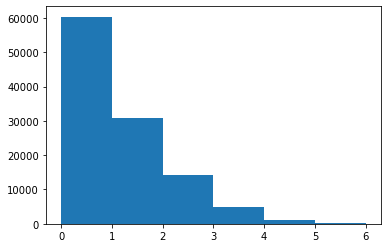

In [17]:
# count number of diseases each person has
all_xray_df['Disease Count'] = split_findings.map(lambda x: len(x) if 'No Finding' not in x else 0)
# plot histogram
plt.hist(all_xray_df['Disease Count'], bins=np.arange(0, 7, 1));
print('Healthy people count:', len(all_xray_df[all_xray_df['Disease Count'] == 0]))
print('Diseased people count:', len(all_xray_df[all_xray_df['Disease Count'] > 0]))

There are far more non-pneumonia cases in this dataset. This is a dataset of pneumonia in the wild, so it's not specifically for pneumonia.

In [18]:
penumonia_pos_count = len(all_xray_df[all_xray_df.Pneumonia == 1])
penumonia_neg_count = len(all_xray_df[all_xray_df.Pneumonia == 0])
print('Patients positive for pneumonia', penumonia_pos_count)
print('Patients negative for pneumonia', penumonia_neg_count)

Patients positive for pneumonia 1431
Patients negative for pneumonia 110689


We see that pneumonia often co-occurs with another disease(s), or is identified as a possible alternative to another diseases 77% of the time.

In [19]:
pneumonia_and_other = len(all_xray_df.loc[(all_xray_df.Pneumonia == 1) & (all_xray_df['Disease Count'] > 1)])
print('Patients positive for pneumonia and another disease', pneumonia_and_other)
print('Proportion', pneumonia_and_other / penumonia_pos_count)

Patients positive for pneumonia and another disease 1109
Proportion 0.7749825296995109


Pneumonia occurs relatively rarely in the wild with 1.3% prevalence in the dataset.

In [20]:
(all_xray_df[unique_labels].sum()/len(all_xray_df)).sort_values(ascending=False)

No Finding            0.538361
Infiltration          0.177435
Effusion              0.118775
Atelectasis           0.103095
Nodule                0.056466
Mass                  0.051570
Pneumothorax          0.047289
Consolidation         0.041625
Pleural_Thickening    0.030191
Cardiomegaly          0.024759
Emphysema             0.022440
Edema                 0.020540
Fibrosis              0.015037
Pneumonia             0.012763
Hernia                0.002025
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

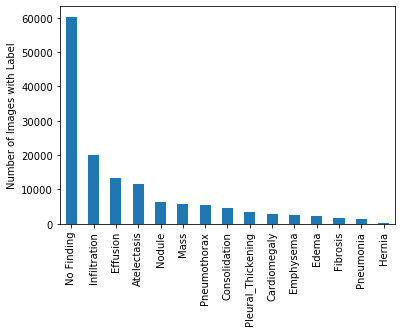

In [21]:
disease_barchart = all_xray_df[unique_labels].sum().sort_values(ascending=False).plot(kind='bar')
disease_barchart.set(ylabel = "Number of Images with Label")

Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences with penumonia. We see pneumonia is often identified along with infiltration and edema. Indeed, pulmonary infiltrates are associated with pneumonia and inflammation due to pneumonia causes fluid leakage and buildup which resembles edema.

Pneumonia                                                       322
Infiltration|Pneumonia                                          199
Edema|Infiltration|Pneumonia                                    137
Atelectasis|Pneumonia                                           108
Edema|Pneumonia                                                  83
                                                               ... 
Fibrosis|Infiltration|Nodule|Pneumonia                            1
Edema|Infiltration|Pleural_Thickening|Pneumonia|Pneumothorax      1
Infiltration|Mass|Pleural_Thickening|Pneumonia                    1
Atelectasis|Emphysema|Infiltration|Pneumothorax|Pneumonia         1
Nodule|Pleural_Thickening|Pneumonia                               1
Name: Finding Labels, Length: 142, dtype: int64


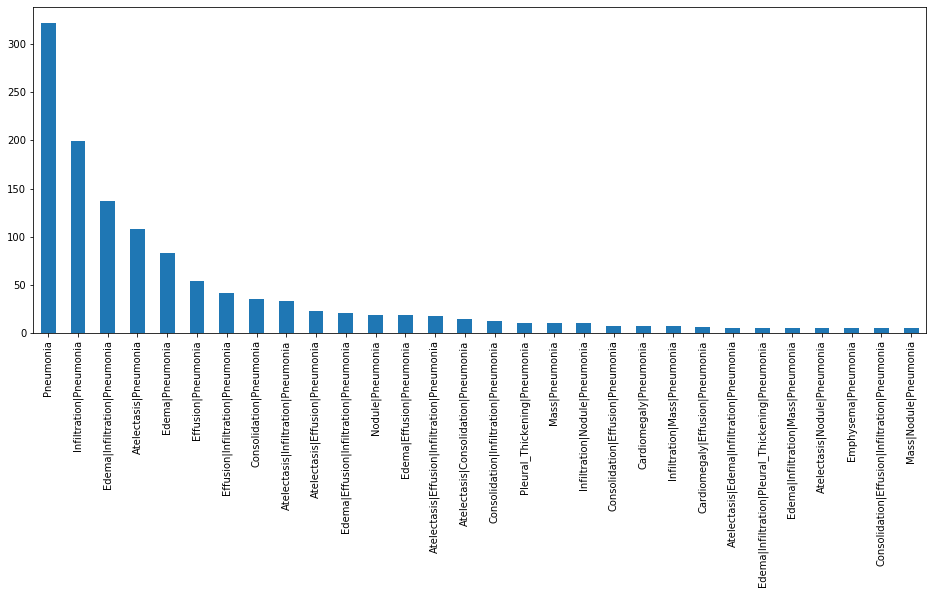

In [22]:
plt.figure(figsize=(16,6))
pneumonia_cooccurences = all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()
print(pneumonia_cooccurences)
pneumonia_cooccurences[0:30].plot(kind='bar')

First filter out the outlier ages (four hundreds).

In [23]:
# patient age
print(all_xray_df['Patient Age'].value_counts()) # we see there are outliers
print('Min age', all_xray_df['Patient Age'].min())
print('Max age', all_xray_df['Patient Age'].max())

58     3209
56     2916
52     2891
55     2830
57     2771
       ... 
411       1
413       1
414       1
95        1
152       1
Name: Patient Age, Length: 107, dtype: int64
Min age 1
Max age 414


In [27]:
from scipy import stats
all_xray_df = all_xray_df[(np.abs(stats.zscore(all_xray_df['Patient Age'])) < 3)] # remove outliers
print(all_xray_df['Patient Age'].value_counts().sort_values())
print('Min age', all_xray_df['Patient Age'].min())
print('Max age', all_xray_df['Patient Age'].max())
print('25th quantile age', all_xray_df["Patient Age"].quantile(0.25))
print('75th quantile age', all_xray_df["Patient Age"].quantile(0.75))

95       1
92       6
94       8
93       9
91      11
      ... 
57    2771
55    2830
52    2891
56    2916
58    3209
Name: Patient Age, Length: 95, dtype: int64
Min age 1
Max age 95
25th quantile age 35.0
75th quantile age 59.0


Now, we see that the dataset contains patients from 1 year old up to 95, with most 20-60 years old.

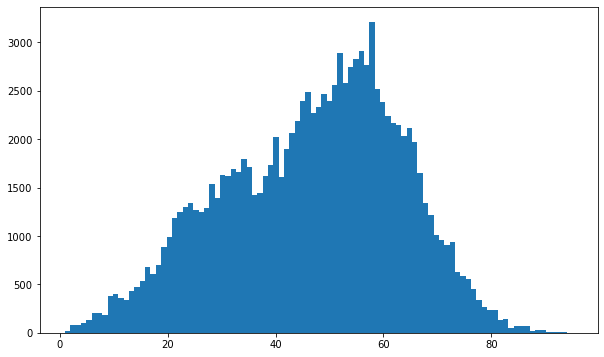

In [28]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'], bins=95);

Most patients with penumonia are between 20 and 70.

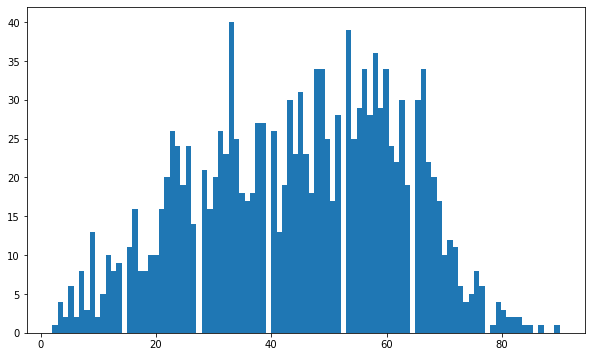

In [29]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'], bins=95);

M    63328
F    48776
Name: Patient Gender, dtype: int64

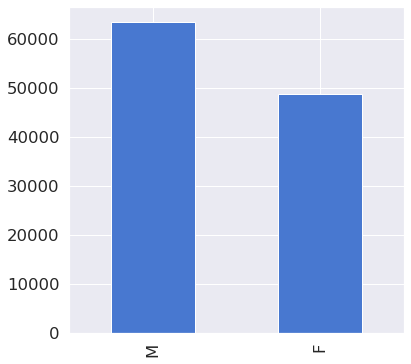

In [67]:
plt.figure(figsize=(6,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')
all_xray_df['Patient Gender'].value_counts()

Pneumonia and conditions associated with pneumonia seem to affect men slightly more often than women.

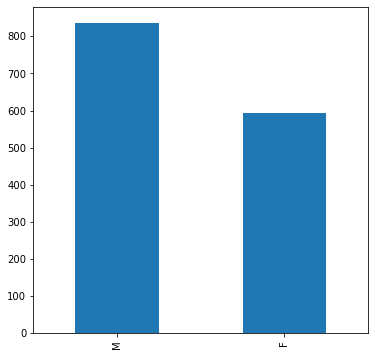

In [32]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia ==1]['Patient Gender'].value_counts().plot(kind='bar')

In [66]:
all_xray_df[all_xray_df.Pneumonia ==1]['Patient Gender'].value_counts()

M    837
F    593
Name: Patient Gender, dtype: int64

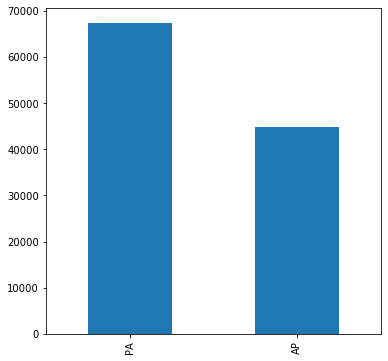

In [33]:
plt.figure(figsize=(6,6))
all_xray_df['View Position'].value_counts().plot(kind='bar')

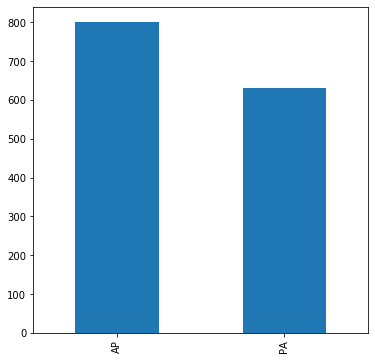

In [34]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia==1]['View Position'].value_counts().plot(kind='bar')

# Pixel analysis

In [35]:
img2path = {os.path.basename(x): x for x in 
                   glob(os.path.join('../p1_data','images*', '*', '*.png'))}

In [36]:
split_findings = sample_df['Finding Labels'].map(lambda x: x.split('|'))
labels = split_findings.tolist()
unique_labels = np.unique(list(chain(*labels)))
print('All Labels ({}): {}'.format(len(unique_labels), unique_labels))

# for each case (row), make a binary flag for whether this person has a disease or not
for l in unique_labels:
    sample_df[l] = sample_df['Finding Labels'].map(lambda finding: 1 if l in finding else 0)
sample_df.sample(3)

All Labels (15): ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


Image Index           Finding Labels  Follow-up #  Patient ID  \
638   00003296_000.png                   Nodule            0        3296   
5036  00026773_000.png               No Finding            0       26773   
3284  00016213_005.png  Edema|Infiltration|Mass            5       16213   

     Patient Age Patient Gender View Position  OriginalImageWidth  \
638         061Y              F            PA                2048   
5036        053Y              F            PA                2992   
3284        033Y              M            AP                2500   

      OriginalImageHeight  OriginalImagePixelSpacing_x  ...  Emphysema  \
638                  2500                        0.171  ...          0   
5036                 2991                        0.143  ...          0   
3284                 2048                        0.168  ...          0   

      Fibrosis  Hernia  Infiltration  Mass  No Finding  Nodule  \
638          0       0             0     0           0       1   
5036         0       0             0     0           1       0   
3284         0       0             1     1           0       0   

      Pleural_Thickening  Pneumonia  Pneumothorax  
638                    0          0             0  
5036                   0          0             0  
3284                   0          0             0  

[3 rows x 26 columns]

In [37]:
from skimage.transform import resize
img_size = (224,224)

def standardize_img(img):
    mean = np.mean(img)
    std = np.std(img)
    img_copy = img.copy()
    img_copy = (img_copy - mean) / std
    return img_copy

# X-Ray images contain a dark background which contributes to a large peak at intensity 0. 
# To have a nicer histogram of intensities for pneumonia, lets remove the background.
def image_mask_selection(img, threshold_low, threshold_up):
    img_copy = img.copy()
    mask = (img_copy > threshold_low) & (img_copy < threshold_up)
    img_copy = img_copy[mask]
    
    return img_copy

def rgb2gray(img):
    rgb_weights = [0.2989, 0.5870, 0.1140]
    return np.dot(img[...,:3], rgb_weights)

def read_img(img_id):
    filepath = img2path[img_id]
    img = mpimg.imread(filepath)
    
    return img

# utility to read in k numpy image arrays for each label
def read_k_images(labels, k):
    data = {}

    for condition in labels:
        data[condition] = []
        #ids = sample_df[sample_df[condition]==1]['Image Index'].tolist()
        ids = sample_df[sample_df[condition]==1]['Image Index'].tolist()
        sampling = random.sample(ids, k=min(k, len(ids)))

        for s_id in sampling:
            np_image = read_img(s_id)
            np_image = resize(np_image, img_size, anti_aliasing=False)
            data[condition].append(np_image.flatten())
        
    return data

def plot_histograms(images, title, limit):
    if limit:
        images = images[:limit]
    for img in images:
        plt.hist(image_mask_selection(img, threshold_low=0.1, threshold_up=0.95),
                 bins=256, histtype='stepfilled', alpha=0.5, 
                 density=True, stacked=True)
        plt.title(title)

Load in and display 3 sample images for each disease (for which it's the only one in the xray).

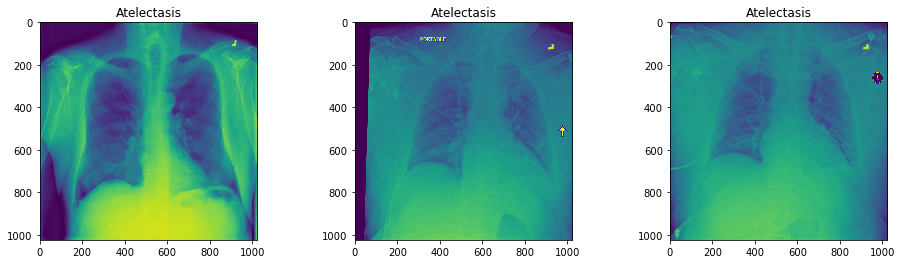

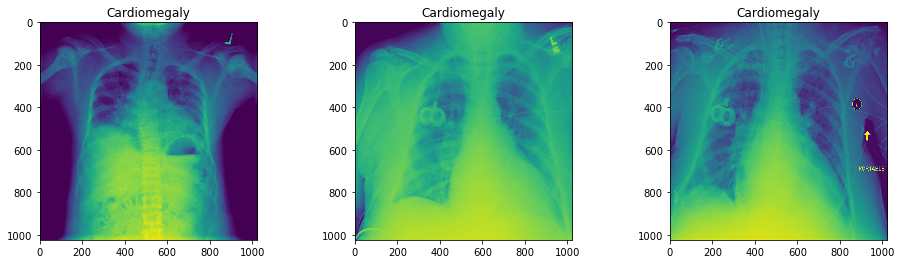

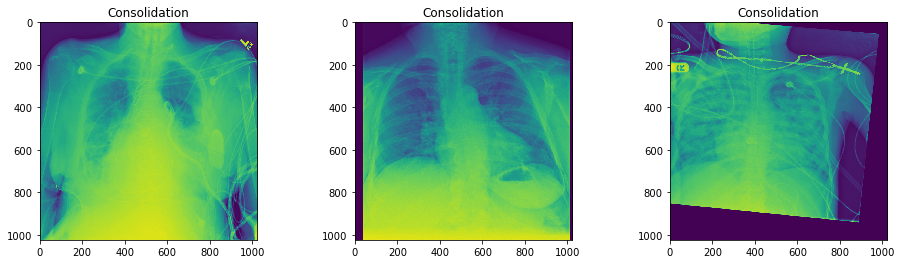

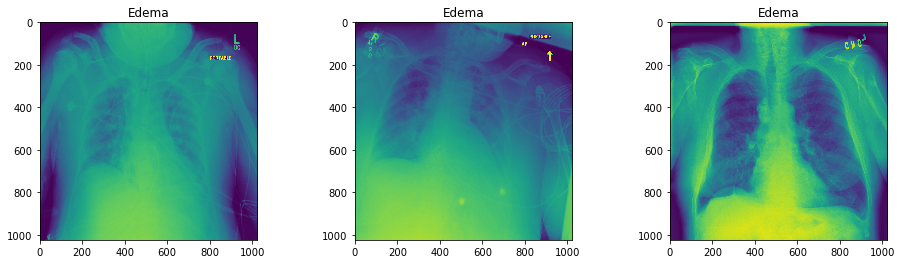

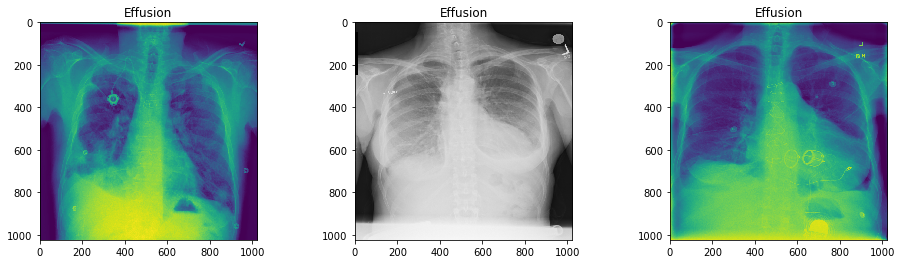

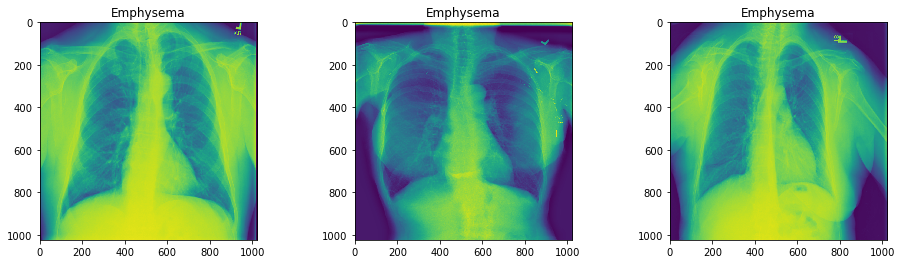

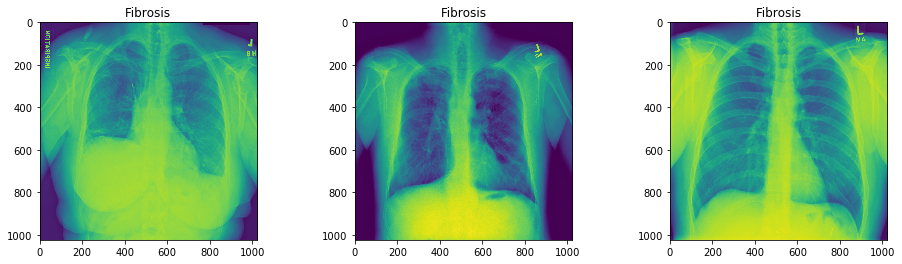

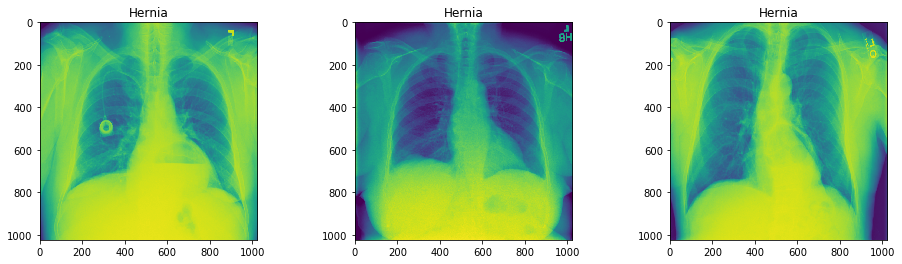

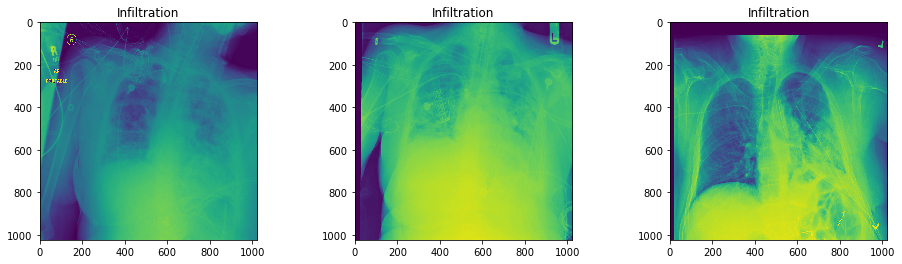

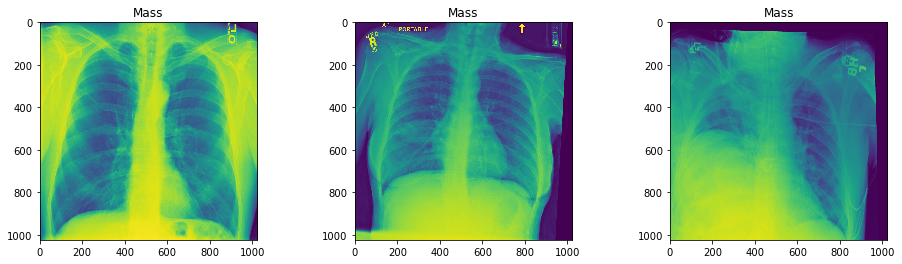

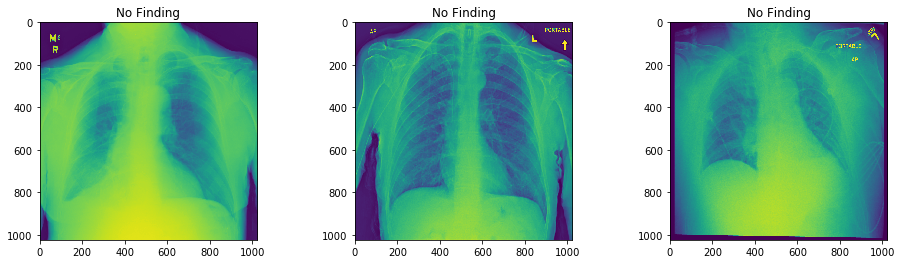

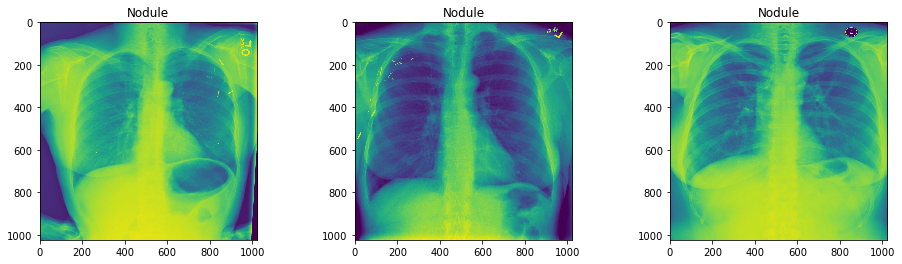

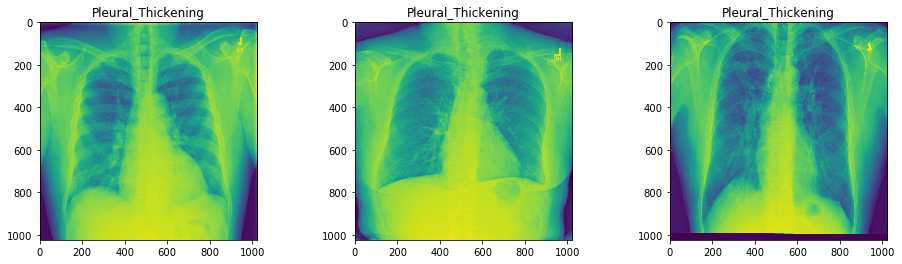

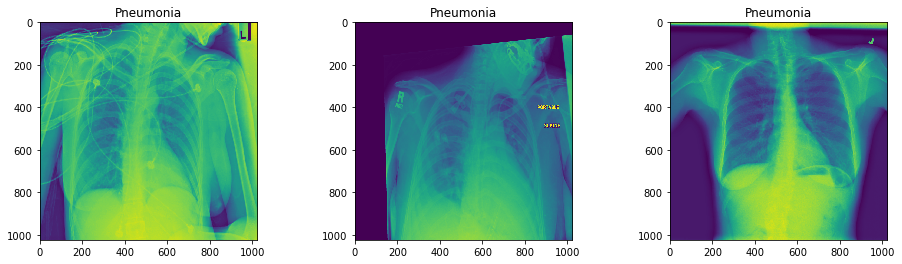

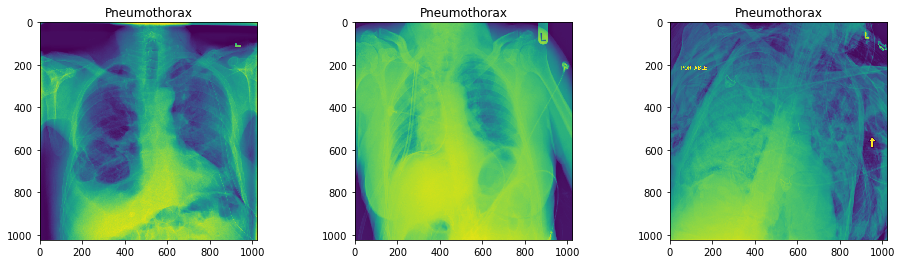

In [51]:
figure = None
for i, label in enumerate(unique_labels):
    for column in [0, 1, 2]:
        if column == 0:
            figure = plt.figure()
            figure.set_figwidth(16)

        x = figure.add_subplot(1, 3, column + 1)
        x.set_title(label)

        index = sample_df[sample_df['Finding Labels'] == label]['Image Index'].tolist()[column]
        image = read_img(index)
        plt.imshow(image)

To the untrained eye, they all look fairly similar.

In [52]:
label2images = read_k_images(unique_labels, k=500)

Lets plot the intensities of the images for pneumonia on top of each other.

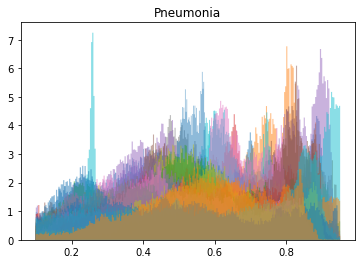

In [53]:
plot_histograms(label2images['Pneumonia'], title="Pneumonia", limit=None)

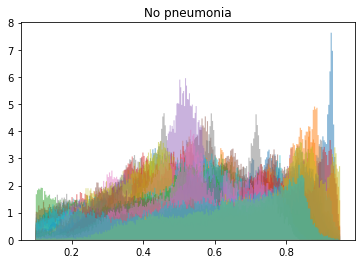

In [54]:
pneumonia_neg_imgs_bylabel = [label2images[label] for label in label2images if label != 'Pneumonia']
pneumonia_neg_imgs = []
for i in pneumonia_neg_imgs_bylabel:
    pneumonia_neg_imgs.extend(i)
plot_histograms(pneumonia_neg_imgs, title='No pneumonia', limit=50)

This isn't too clear - there are peaks all over the range of pixel values.

Now lets plot a summarized histogram of the intensities by finding. Perhaps that will be clearer than the above.

In [55]:
def get_condition_intensities(condition_images, threshold_low, threshold_up):
    intensities = []
    condition_images = condition_images[:min(500, len(condition_images))]
    
    for img in condition_images:
        image = image_mask_selection(img, threshold_low, threshold_up)
        intensities.extend(image.flatten())
    return intensities

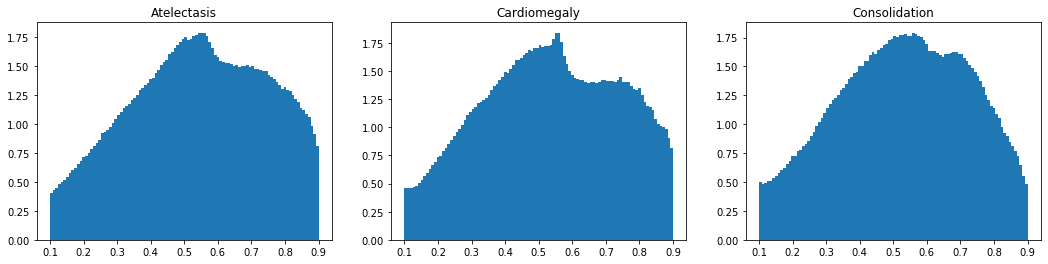

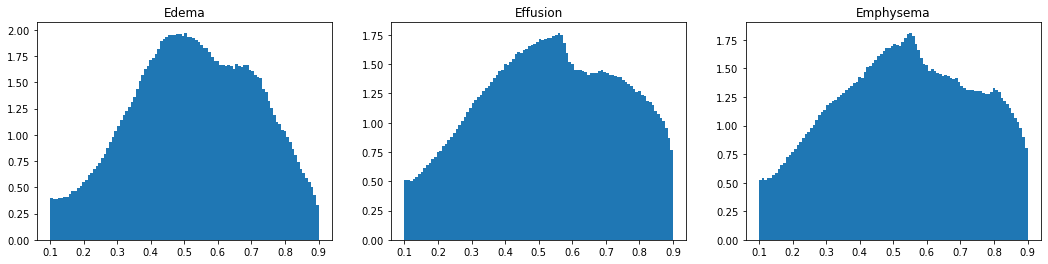

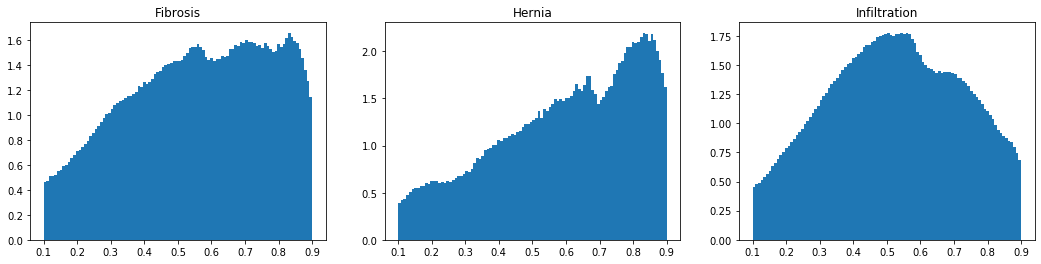

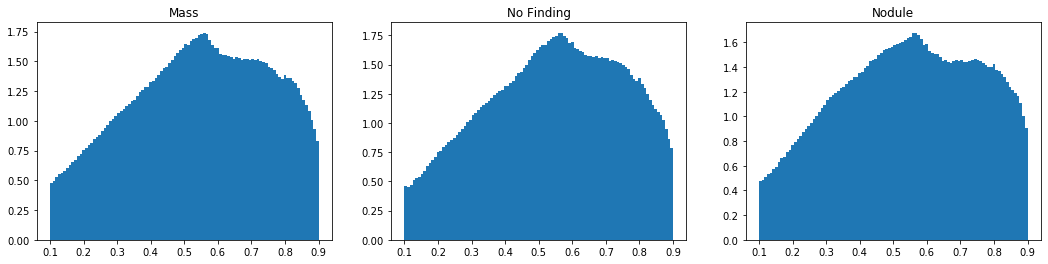

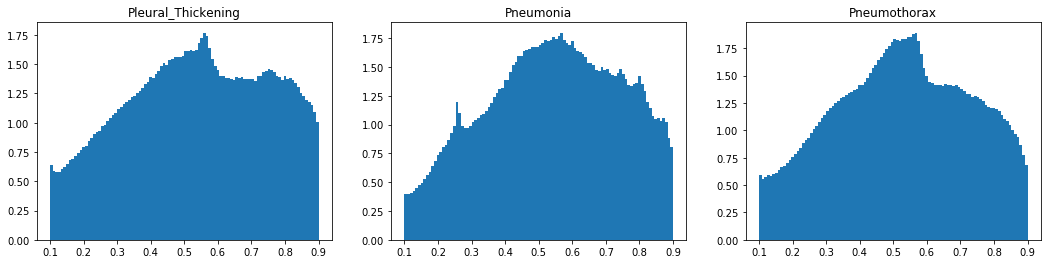

In [56]:
figure = None
for i, label in enumerate(unique_labels):
    column = i % 3
    if column == 0:
        figure = plt.figure()
        figure.set_figwidth(18)
    
    x = figure.add_subplot(1, 3, column + 1)
    x.set_title(label)

    intensities = get_condition_intensities(label2images[label], 0.1, 0.9)
    plt.hist(intensities, bins=100, density=True)

There are many similarities in the distribution shapes even after subtracting the black background and bright artifacts. Generally, up to 0.5, the distributions are the same. After 0.5, most diseases drop in intensity, then level out, and then drop again around 0.8. The exception is pneumonia which has a roughly linear decrease. Still, it's quite similar to 'No Finding', 'Mass', somewhat similar to 'Infiltration' and 'Atelecstasis'. 

Fibrosis and Hernia are the only two conditions that exhibit a continuous increase in intensity.

## PCA and t-SNE

Lets plot some PCA and t-SNE visualizations. I don't expect much given the similarities between x-rays, but I'm curious to see how it works. I'm going to run PCA with 50 dimensions, then pass the output to t-SNE based on the recommendation in Scikit-learn's documention:
```
It is highly recommended to use another dimensionality reduction method (e.g., PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g., 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples.
```

In [57]:
# Utility function to visualize the outputs of PCA and t-SNE
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
seed = 123
def scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [58]:
label2index = {label: i for i, label in enumerate(unique_labels)}

In [59]:
def gen_dim_reduction_data(label2images):
    images, labels = [], []
    for label in label2images:
        disease_imgs = label2images[label]
        bad_imgs_idxs = []
        for i, img in enumerate(disease_imgs):
            if img.shape != (img_size[0]*img_size[1],):
                bad_imgs_idxs.append(i)
                
        disease_imgs = [img for i, img in enumerate(disease_imgs) if i not in bad_imgs_idxs]
        
        np_disease_imgs = np.array(disease_imgs)
        print(label, np_disease_imgs.shape) # shape: (10, 224*224)
        
        images.extend(np_disease_imgs)

        label_index = label2index[label]
        labels.extend([label_index] * len(disease_imgs))
    return np.array(images), np.array(labels)

dim_reduction_imgs, dim_reduction_labels = gen_dim_reduction_data(label2images)
print(dim_reduction_imgs.shape, dim_reduction_labels.shape)

Atelectasis (498, 50176)
Cardiomegaly (140, 50176)
Consolidation (225, 50176)
Edema (117, 50176)
Effusion (498, 50176)
Emphysema (126, 50176)
Fibrosis (84, 50176)
Hernia (13, 50176)
Infiltration (500, 50176)
Mass (283, 50176)
No Finding (499, 50176)
Nodule (313, 50176)
Pleural_Thickening (176, 50176)
Pneumonia (61, 50176)
Pneumothorax (271, 50176)
(3804, 50176) (3804,)


In [60]:
time_start = time.time()

pca = PCA(n_components=50)
pca_result = pca.fit_transform(dim_reduction_imgs)

print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

PCA done! Time elapsed: 3.6626803874969482 seconds


In [61]:
pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]

print('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

Variance explained per principal component: [0.2556967  0.09158545 0.08187278 0.07175682 0.06268954 0.03774341
 0.0280767  0.02152357 0.01970834 0.01556243 0.01484005 0.01316784
 0.01268153 0.01127605 0.00983581 0.00918119 0.0082991  0.00772249
 0.00745005 0.0071742  0.00597937 0.005471   0.00517596 0.00488633
 0.00455779 0.00448703 0.00434609 0.00394409 0.00370878 0.0036592
 0.00352947 0.00330883 0.00306017 0.00281307 0.00266394 0.00252038
 0.00245369 0.00233299 0.00225534 0.00211219 0.00205621 0.0018712
 0.00179313 0.00172393 0.00171031 0.00163442 0.00153937 0.0014745
 0.00141885 0.00135735]


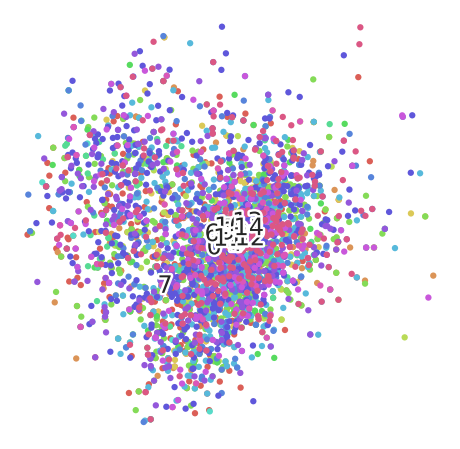

In [62]:
top_two_comp = pca_df[['pca1','pca2']] # taking first and second principal component
scatter(top_two_comp.values,dim_reduction_labels); # Visualizing the PCA output

In [63]:
from sklearn.manifold import TSNE

time_start = time.time()

tsne = TSNE(random_state=seed).fit_transform(pca_result)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 9.66408085823059 seconds


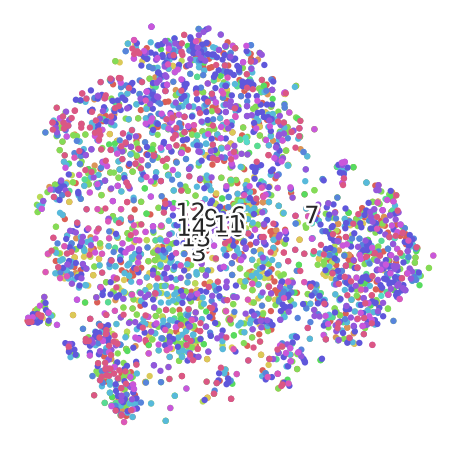

In [64]:
scatter(tsne, dim_reduction_labels);

In [65]:
label2index

{'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Consolidation': 2,
 'Edema': 3,
 'Effusion': 4,
 'Emphysema': 5,
 'Fibrosis': 6,
 'Hernia': 7,
 'Infiltration': 8,
 'Mass': 9,
 'No Finding': 10,
 'Nodule': 11,
 'Pleural_Thickening': 12,
 'Pneumonia': 13,
 'Pneumothorax': 14}

## Conclusions

- The pixel intensity distributions are quite similar and almost indistinguishable. Using a thresholding approach to filter for specific diseases won't work.
- The conditions affect different areas of the chest and therefore appear in different places on the xray, potentially with the same pixel intensities. Thus, it's possible to have histograms for different diseases with the same distributions, even if the intensity concentration is in different areas of the x-ray. Thus, a CNN with spatial recognition is helpful.
- Distribution from pixel intensities [0.1, 0.5] is the same for all diseases
- from [0.5, 0.9], there are some minor differences, with the exception of hernias and fibrosis which differ greatly from the rest.
- The PCA and t-SNE analysis did not reveal any separable groups.
- Need to filter out the [0, 0.1] and [0.9, 1.0] intensities to remove black background noise and artifacts.